# Image Classification of COVID-19 X-rays

## Data

 structure:
Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## Binary Classification: COVID-19 vs. Normal

In [1]:
import os

import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import math

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.12.0'

In [2]:
# List all physical devices detected by TensorFlow
devices = tf.config.list_physical_devices()
print("Available devices:")
print(devices)

# Check for GPU availability
gpu_available = tf.config.list_physical_devices('GPU')
if gpu_available:
    print("GPU is available.")
else:
    print("GPU is not available, using CPU.")

Available devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPU is not available, using CPU.


#### Load Image Data

In [3]:
DATA_LIST = os.listdir('../Data/Covid_Data_GradientCrescent/two/train')
DATASET_PATH  = '../Data/Covid_Data_GradientCrescent/two/train'
TEST_DIR =  '../Data/Covid_Data_GradientCrescent/two/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 256  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 60
LEARNING_RATE = 0.000005 # start off with high rate first 0.001 and experiment with reducing it gradually 

#### Generate Training and Validation Batches

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   channel_shift_range = 20,
                                   horizontal_flip = True,
                                   zoom_range = 0.1,
                                   rotation_range = 10,
                                   width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    shear_range = 0.1,
                                    brightness_range = [0.5,1.5],   
                                   validation_split = 0.2, fill_mode='nearest')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=32,
                                                  class_mode="binary")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",seed=22,
                                                  class_mode="binary")

Found 104 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


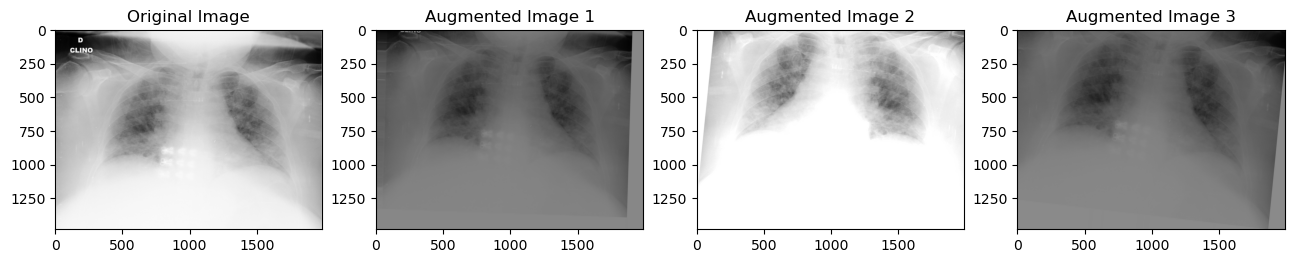

In [5]:
# Show the effect of data augmentation
img = load_img('../Data/Covid_Data_GradientCrescent/two/train/covid/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg') 
x = img_to_array(img)  
x = np.expand_dims(x, axis=0) 
augmented_images = train_datagen.flow(x, batch_size=1)
plt.figure(figsize=(20, 10))
plt.subplot(2, 5, 1)
plt.imshow(img)
plt.title('Original Image')

# Generate and plot 8 augmented images
for i in range(2, 5):
    batch = next(augmented_images)  
    aug_img = batch[0]  
    plt.subplot(2, 5, i)
    plt.imshow(aug_img)
    plt.title(f'Augmented Image {i-1}')
plt.show()

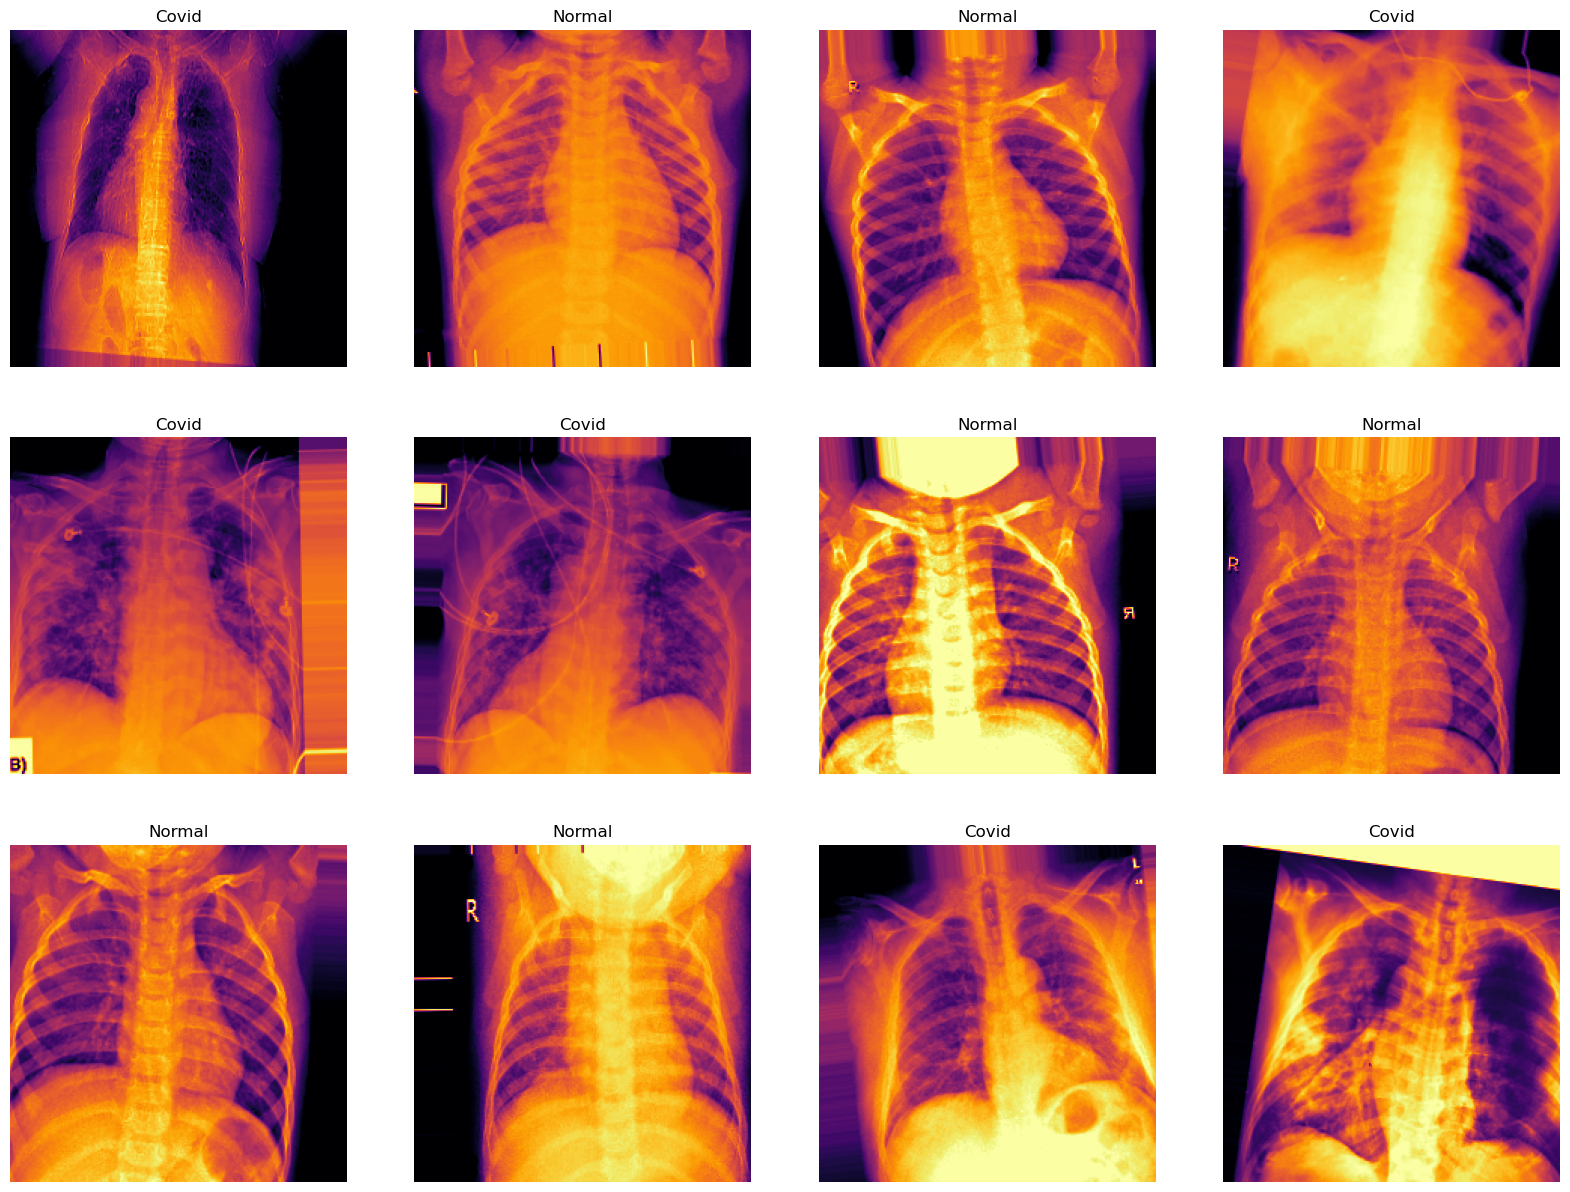

In [6]:
# Use a clearer color for viewing samples
def image_plot(generator,image_numbers):
    img_feature = generator[0][0][:image_numbers]
    img_label = generator[0][1][:image_numbers]

    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(tf.image.rgb_to_grayscale(img_feature[i]), cmap='inferno')
        plt.title("Covid" if img_label[i] == 0 else "Normal")
        plt.axis("off")

image_plot(train_batches,12)

#### Build Model 

In [7]:
from tensorflow.keras import layers, models
VGG16_base= tf.keras.applications.VGG16(include_top=False,weights="imagenet",input_shape=(224, 224, 3))
inputs = VGG16_base.input  # Use VGG16 input
x = VGG16_base.output  # Start with VGG16 output
VGG16_base.trainable = False  # Freeze the VGG16 layers
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu', name='dense_feature1')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(128, activation='relu', name='dense_feature2')(x)
outputs = layers.Dense(1, activation='sigmoid')(x) 

# Final model
model = models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

#### Train Model

In [9]:
#FIT MODEL
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_two.h5', monitor='accuracy', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=8)
callbacks_list = [checkpoint,early]
history = model.fit(train_batches,  epochs=NUM_EPOCHS, validation_data=valid_batches,shuffle=False, 
        verbose=True, callbacks=callbacks_list) # Use correct args here.

Epoch 1/60


2024-03-11 19:16:00.273689: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - ETA: 0s - loss: 0.7334 - accuracy: 0.4038
Epoch 1: accuracy improved from -inf to 0.40385, saving model to model/vgg16_two.h5
1/1 [==============================] - 15s 15s/step - loss: 0.7334 - accuracy: 0.4038 - val_loss: 0.7191 - val_accuracy: 0.5000
Epoch 2/60
1/1 [==============================] - ETA: 0s - loss: 0.7115 - accuracy: 0.4712
Epoch 2: accuracy improved from 0.40385 to 0.47115, saving model to model/vgg16_two.h5
1/1 [==============================] - 14s 14s/step - loss: 0.7115 - accuracy: 0.4712 - val_loss: 0.6996 - val_accuracy: 0.5385
Epoch 3/60
1/1 [==============================] - ETA: 0s - loss: 0.7024 - accuracy: 0.4808
Epoch 3: accuracy improved from 0.47115 to 0.48077, saving model to model/vgg16_two.h5
1/1 [==============================] - 14s 14s/step - loss: 0.7024 - accuracy: 0.4808 - val_loss: 0.7195 - val_accuracy: 0.3846
Epoch 4/60
1/1 [==============================] - ETA: 0s - loss: 0.6889 - accuracy: 0.5769
E

#### Plot Accuracy and Loss During Training

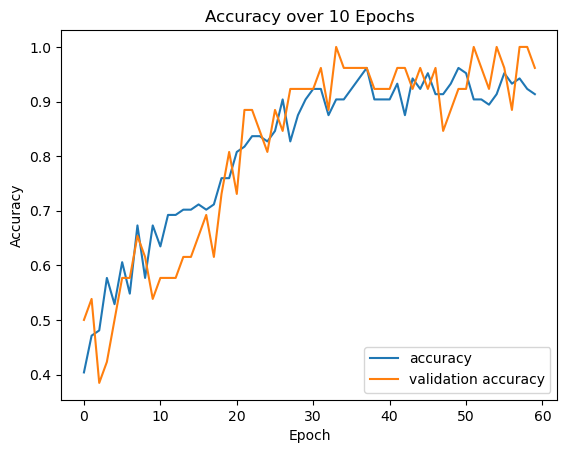

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over 10 Epochs')
plt.legend(loc='lower right')


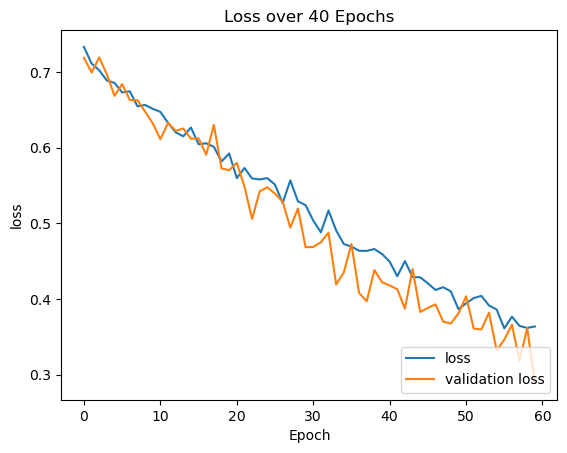

In [11]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Loss over 40 Epochs')
plt.legend(loc='lower right')

#### Plot Test Results

Found 18 images belonging to 2 classes.
18/18 [==============================] - 5s 270ms/step


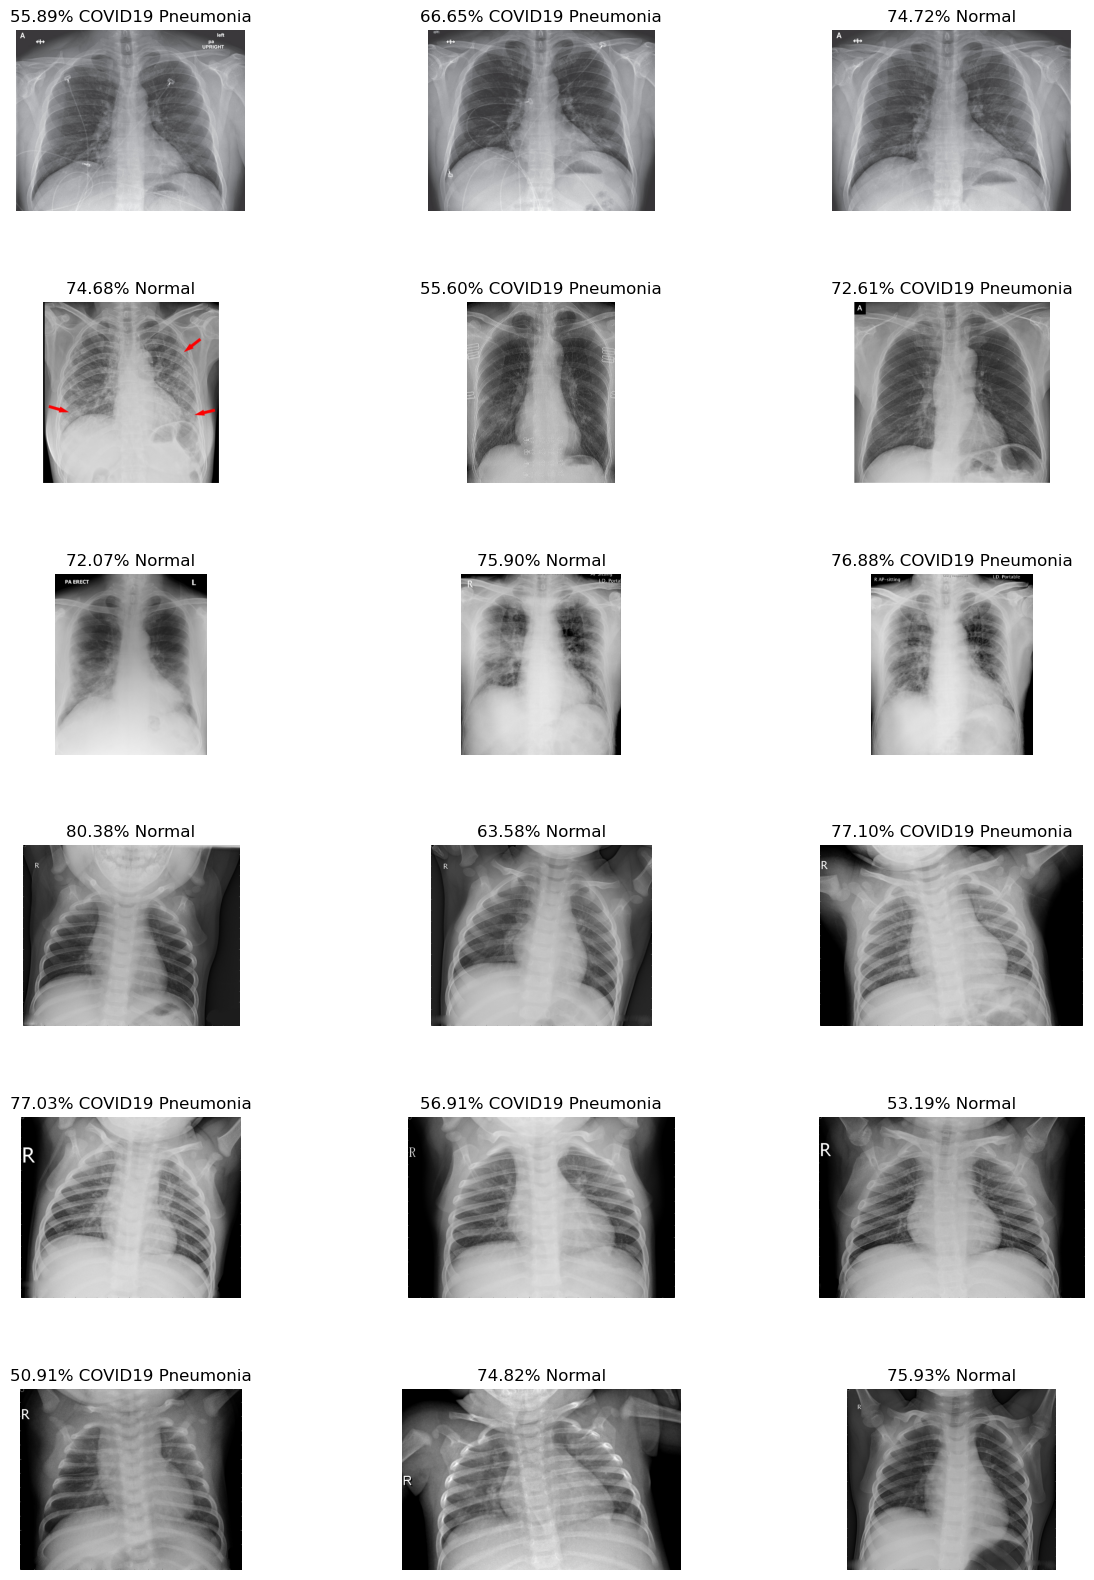

In [24]:
import matplotlib.image as mpimg
test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  channel_shift_range = 20,
                                   horizontal_flip = True,
                                   zoom_range = 0.1,
                                   rotation_range = 10,
                                   width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    shear_range = 0.1,
                                    brightness_range = [0.5,1.5], 
                                    fill_mode='nearest')
test_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,class_mode="binary")
test_generator.reset()
pred = model.predict(test_generator,verbose=1)

fig, axs = plt.subplots(6, 3, figsize=(15, 20))
fig.subplots_adjust(hspace=0.5)

for index, probability in enumerate(pred):
    image_path = TEST_DIR + "/" +test_generator.filenames[index]
    image = mpimg.imread(image_path)
    if image.ndim < 3:
        image = np.reshape(image,(image.shape[0],image.shape[1],1))
        image = np.concatenate([image, image, image], 2)

    pixels = np.array(image)
    ax = axs[index // 3, index % 3]
    ax.imshow(pixels)
    ax.axis('off')
    
    if probability > 0.5:
        ax.set_title("%.2f" % (probability[0]*100) + "% Normal")
    else:
        ax.set_title("%.2f" % ((1-probability[0])*100) + "% COVID19 Pneumonia")

plt.show()


In [37]:
test_generator.reset()
x = model.evaluate(test_generator,steps = np.ceil(len(test_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

18/18 [==============================] - 5s 282ms/step - loss: 0.4213 - accuracy: 0.9444
Test loss: 0.42127811908721924
Test accuracy: 0.9444444179534912


## Confusion Matrix of model

Found 18 images belonging to 2 classes.
18/18 [==============================] - 5s 280ms/step


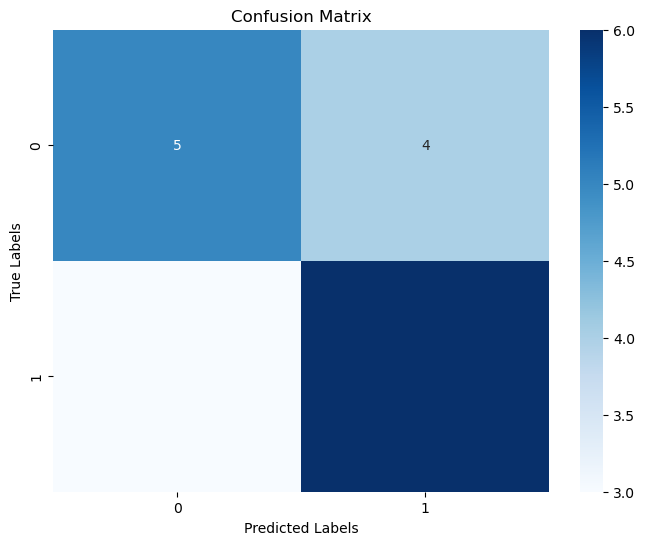

In [38]:
import seaborn as sns

# Get the true labels and predicted labels
test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  channel_shift_range = 20,
                                   horizontal_flip = True,
                                   zoom_range = 0.1,
                                   rotation_range = 10,
                                   width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    shear_range = 0.1,
                                    brightness_range = [0.5,1.5], 
                                   fill_mode='nearest')
test_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,class_mode="binary")
test_generator.reset()
true_labels = test_generator.classes
predicted_labels = model.predict(test_generator)
pred_result=[1 if i > 0.5 else 0 for i in predicted_labels]
cm = confusion_matrix(true_labels, pred_result)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

In [15]:
from sklearn.manifold import TSNE
from tensorflow.keras import models

intermediate_layer_model = models.Model(inputs=model.input,
                                        outputs=model.get_layer('dense_feature2').output)
tsne_data_generator = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="binary")

labels = []
tsne_inputs = []
for i in range(len(tsne_data_generator)):
    feature, label = tsne_data_generator[i]
    y = intermediate_layer_model(feature)
    if label == 0:
        labels.append("Covid")
    else:
        labels.append("Normal")
    tsne_inputs.append(y[0])
tsne_inputs = np.array(tsne_inputs)


Found 130 images belonging to 2 classes.


In [16]:
tsne_result = TSNE(n_components=2, random_state=0).fit_transform(tsne_inputs)
tsne_result.shape

(130, 2)

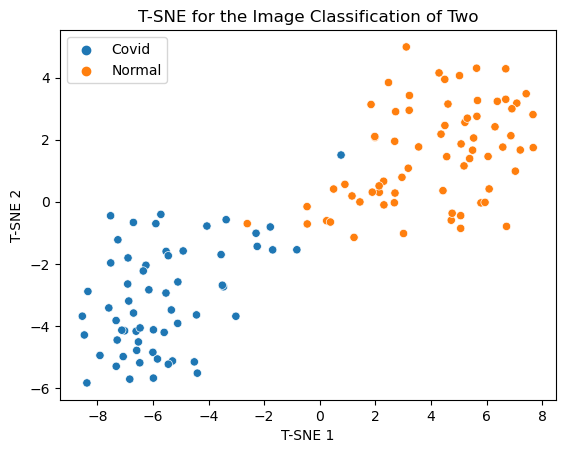

In [17]:
tsne_result_df = pd.DataFrame({'T-SNE 1': tsne_result[:,0], 'T-SNE 2': tsne_result[:,1], 'label': labels})
sns.scatterplot(x='T-SNE 1', y='T-SNE 2', hue='label', data=tsne_result_df)
plt.title("T-SNE for the Image Classification of Two")
plt.legend()
plt.show()
                

## Heatmap

In [18]:
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        # Check if layer is convolutional
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None

last_conv_layer_name = find_last_conv_layer(VGG16_base)
print("Last Conv Layer:", last_conv_layer_name)

Last Conv Layer: block5_conv3


In [19]:
import cv2
import numpy as np
import tensorflow.keras.backend as K

def get_heatmap(model, img_path, layer_name):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    pred_class = np.argmax(model.predict(img))

    heatmap_model = tf.keras.models.Model([model.inputs], [VGG16_base.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = heatmap_model(img)
        if pred_class is None:
            pred_class = tf.argmax(predictions[0])
        loss = predictions[:, pred_class]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = np.squeeze(heatmap)
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.expand_dims(heatmap, axis=-1) 
    heatmap = np.uint8(255 * heatmap)
    
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    img_uint8 = np.uint8(255 * img[0]) 
    superimposed_img = cv2.addWeighted(img_uint8, 0.6, heatmap, 0.4, 0)

    return superimposed_img


1/1 [==============================] - 0s 402ms/step


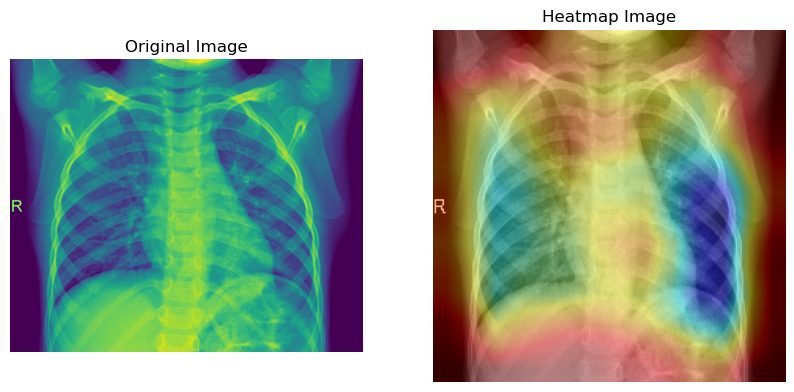

In [20]:
# Provide the path to the image you want to test
image_path = "../Data/Covid_Data_GradientCrescent/two/train/normal/NORMAL2-IM-1281-0001.jpeg"

# Provide the layer name of the last convolutional layer
last_conv_layer_name = "block5_conv3"

# Call the get_heatmap function
heatmap_image = get_heatmap(model, image_path, last_conv_layer_name)

# Display the original image and the heatmap image
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(hspace=0.5)

# Load and display the original image
original_image = mpimg.imread(image_path)
axs[0].imshow(original_image)
axs[0].axis('off')
axs[0].set_title('Original Image')

# Display the heatmap image
axs[1].imshow(heatmap_image)
axs[1].axis('off')
axs[1].set_title('Heatmap Image')

plt.show()


1/1 [==============================] - 0s 258ms/step


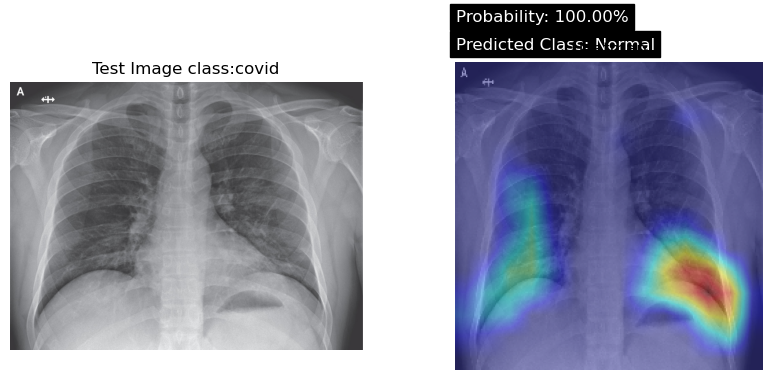

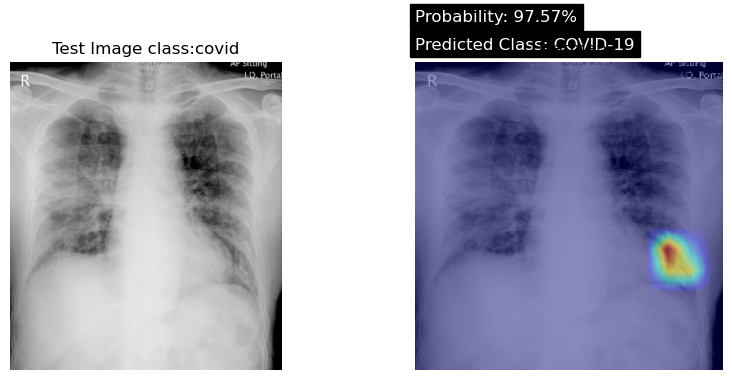

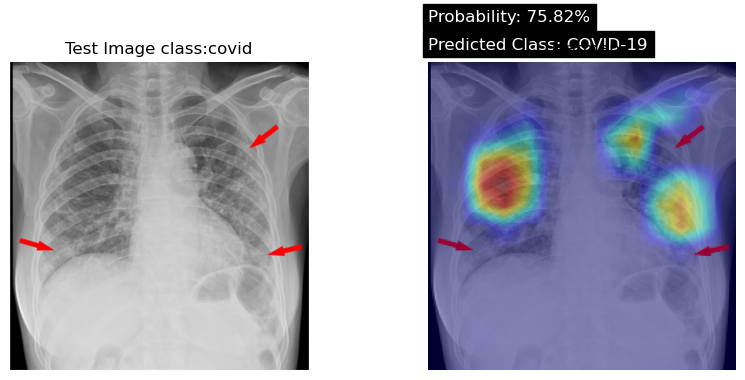

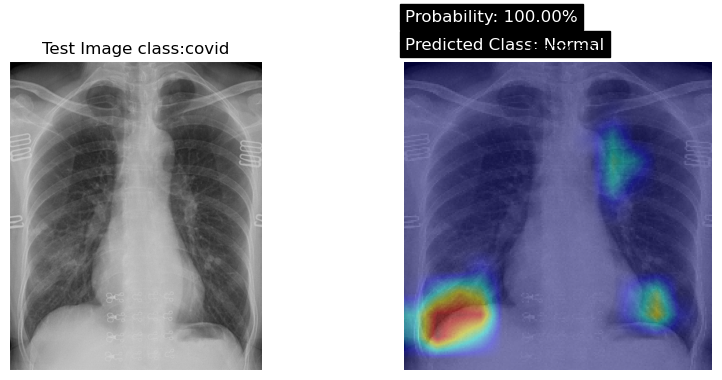

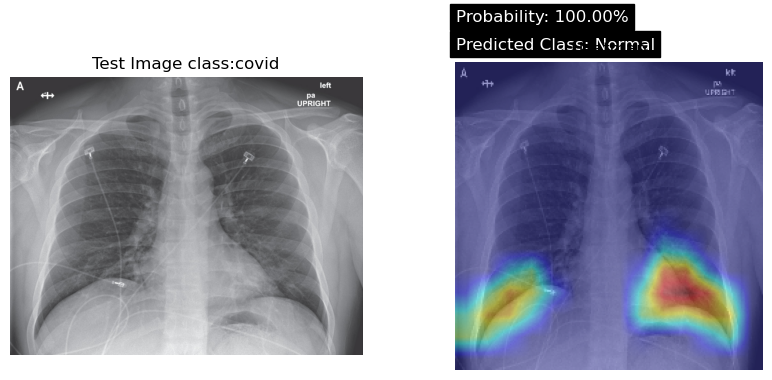

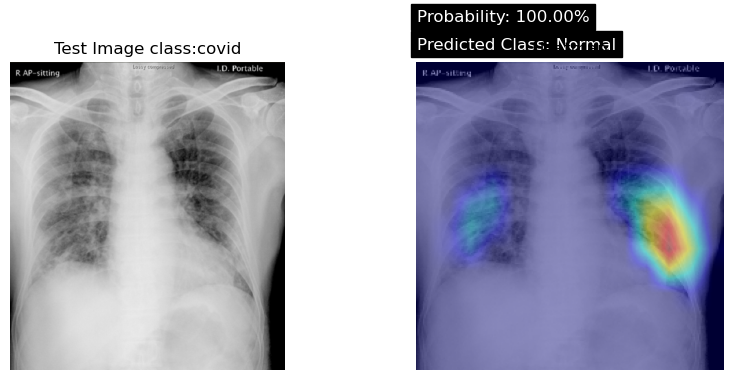

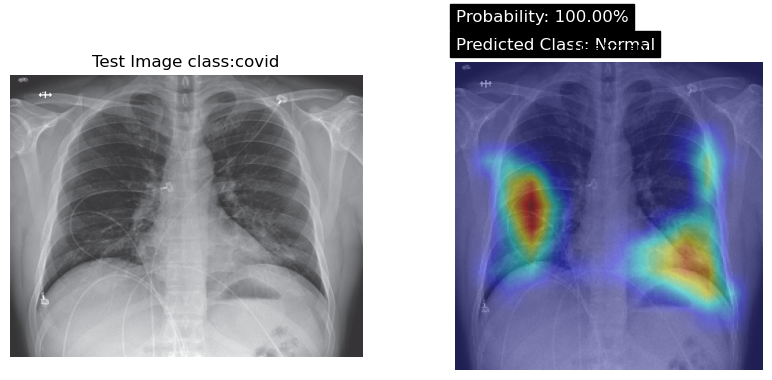

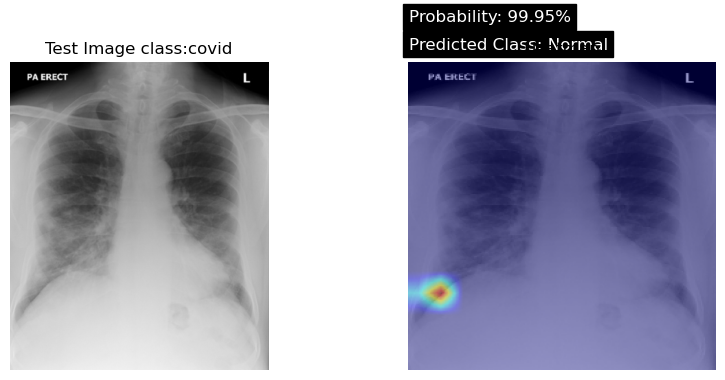

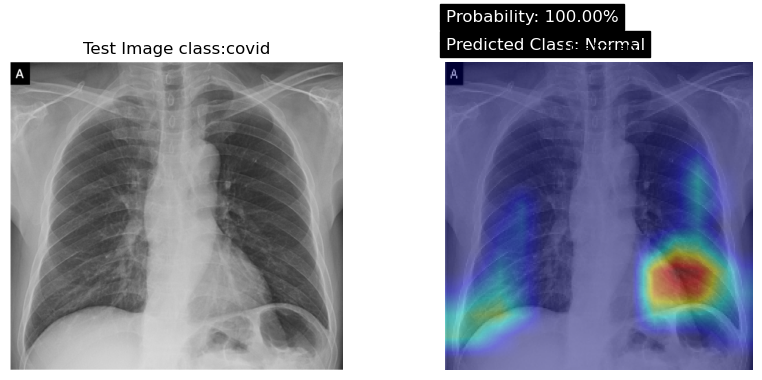

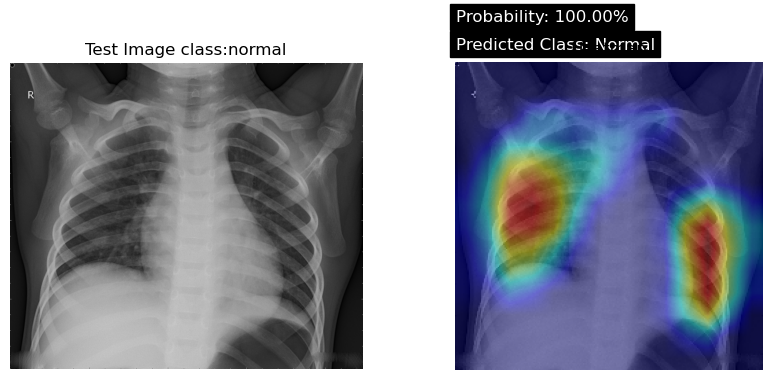

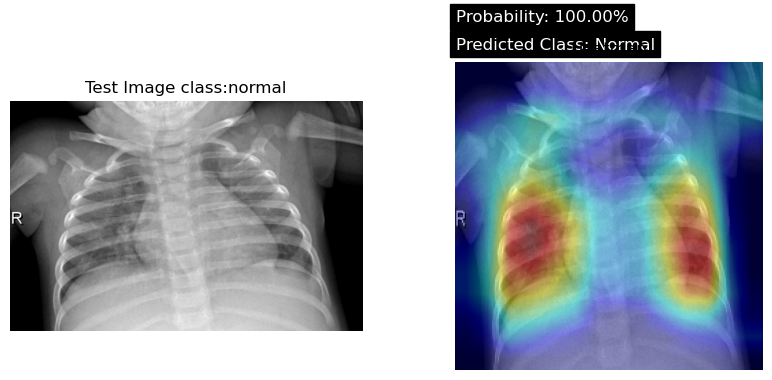

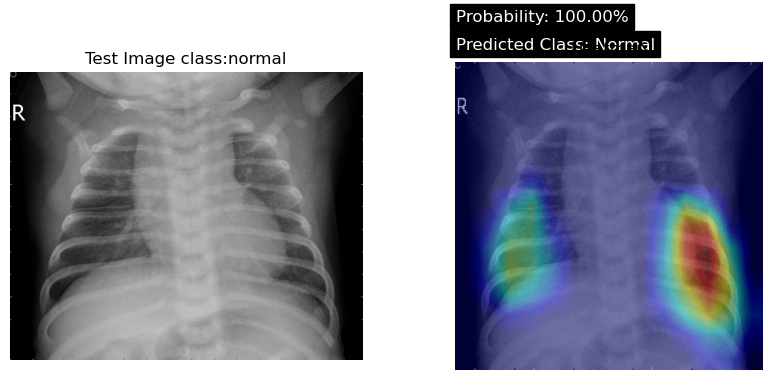

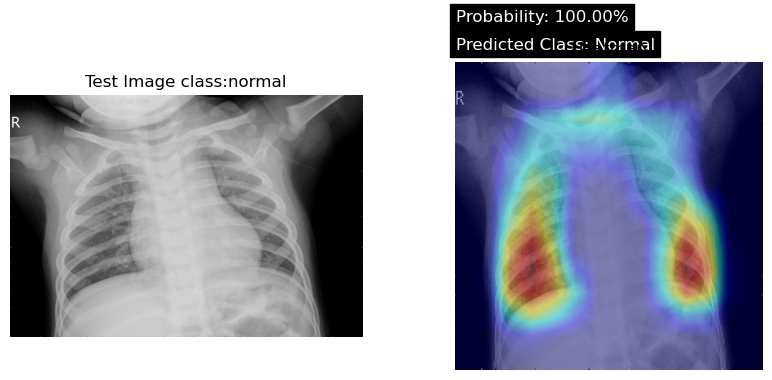

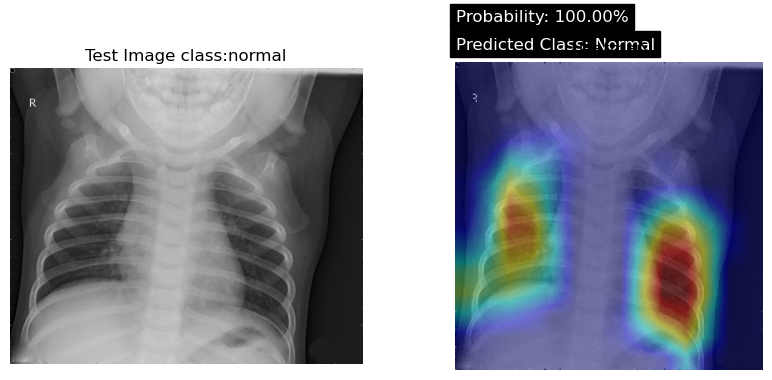

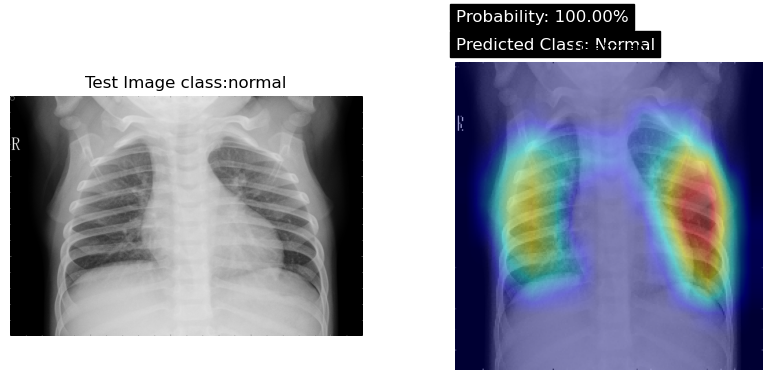

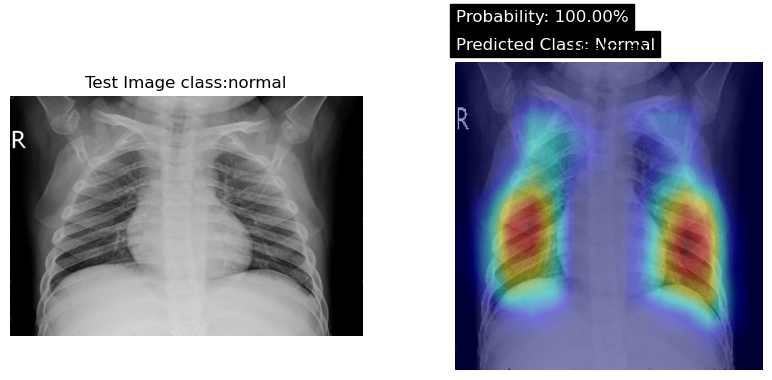

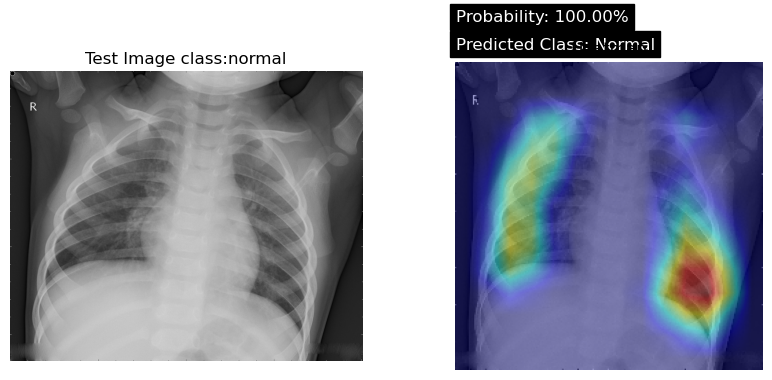

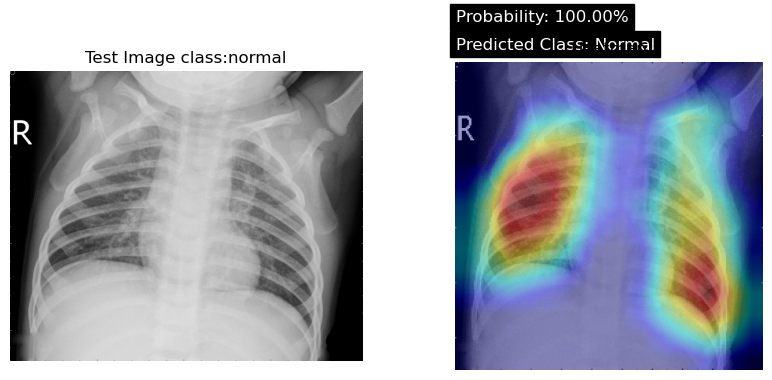

In [21]:
import os
import matplotlib.pyplot as plt

# Path to the test images directory
test_images_dir = '../Data/Covid_Data_GradientCrescent/two/test'

# Get the list of test images
test_images = os.listdir(test_images_dir)

# Loop through each test image
for image_name in ['covid', 'normal']:
    # Get the path to the test image
    class_path = os.path.join(test_images_dir, image_name)
    for img in os.listdir(class_path):
        image_path = os.path.join(class_path, img)
        # Get the heatmap for the test image

        heatmap = get_heatmap(model, image_path, last_conv_layer_name)
    
        # Load the test image
        test_image = cv2.imread(image_path)
    
        # Plot the test image
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
        plt.title(f'Test Image class:{image_name}')
        plt.axis('off')
        
        # Plot the heatmap
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB))
        plt.title('Heatmap')
        plt.axis('off')
        
        # Get the predicted class and probability
        img = load_img(image_path, target_size=IMAGE_SIZE)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        pred = model.predict(x)
        if pred > 0.5:
            predicted_class = 'Normal'
            probability = pred[0][0] * 100
        else:
            predicted_class = 'COVID-19'
            probability = (1 - pred[0][0]) * 100
        
        plt.text(0, -10, f'Predicted Class: {predicted_class}', fontsize=12, color='white', backgroundcolor='black')
        plt.text(0, -30, f'Probability: {probability:.2f}%', fontsize=12, color='white', backgroundcolor='black')
        plt.axis('off')
        

<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->